Number of times null hypothesis is rejected: 297 out of 1000 simulations
Type 1 Error: 0.297
Bias for Coefficient of Treatment : -0.00038788933746451134
MSE for Coefficient of Treatment : 8.54577635311013e-05
RMSE for Coefficient of Treatment : 0.009244336835657889
Average Standard Error: 0.009059270564528902
Standard Error of the beta_1 distribution: 0.01700628870183059
The confidence interval is (-0.03372021519305247, {0.03294443651812345})


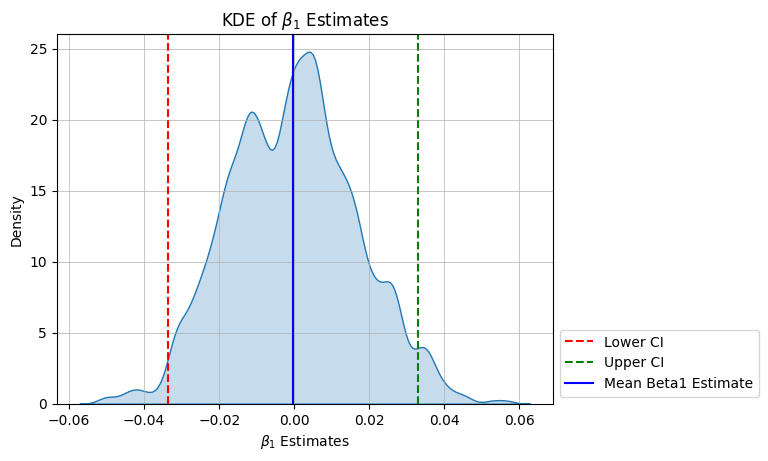

In [25]:
file_path = r'C:\Users\sneha\Downloads\cps_00006.csv.gz'

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from cps_data_agg import process_cps_data

alpha = 0.05  # Significance level
num_simulations = 1000
num_of_states = 10


reject_count = 0  # Counter for the number of rejections
true_beta1_value = 0   # Initialising the counters
bias_values = []
squared_error_values = []
standard_error_values =[]
beta1_estimates = []


np.random.seed(42) # setting seed for reproducibility

df = process_cps_data(file_path)  # importing the data from process_cps_data module

for _ in range(num_simulations):

    data = df.copy()

    unique_statefips = data['STATEFIP'].unique()
    selected_statefips = np.random.choice(unique_statefips, size=num_of_states, replace=False)

    # Filter the DataFrame to only include rows with the selected STATEFIPs
    data = data[data['STATEFIP'].isin(selected_statefips)]
    
    states = data['STATEFIP'].unique()
    
    # Randomly selecting  half of the states to be in the treatment group
    
    treatment_states = np.random.choice(states, size=len(states)//2, replace=False)

    # Assigning treatment year to each treatment state, staggered between 1985 and 1995

    treatment_years = np.random.choice(range(1985, 1995), size=len(treatment_states), replace=True)
    state_to_treatment_year = dict(zip(treatment_states, treatment_years))

    # Adding a treatment column to the DataFrame

    data['TREATMENT'] = data.apply(lambda x: 1 if x['STATEFIP'] in treatment_states and x['YEAR'] >= state_to_treatment_year[x['STATEFIP']] else 0, axis=1)
  
    dummy_df = pd.get_dummies(data['STATEFIP'], prefix='STATEFIP', drop_first=True).astype(int)

    # Concatenate the dummy variables with the original DataFrame
    data = pd.concat([data, dummy_df], axis=1)

    dummy_df2 = pd.get_dummies(data['YEAR'], prefix='YEAR', drop_first=True).astype(int)

    # Concatenate the dummy variables with the original DataFrame
    data = pd.concat([data, dummy_df2], axis=1)

    columns_to_exclude = ['STATEFIP', 'YEAR', 'Residuals']

    X_columns =[col for col in data.columns if col not in columns_to_exclude]

    X = data[X_columns]

    X = sm.add_constant(X)
    Y = data['Residuals'] 
    model = sm.OLS(Y, X).fit()

    bias_value = model.params['TREATMENT'] - true_beta1_value
    
    bias_values.append(bias_value)

    squared_error = (model.params['TREATMENT'] - true_beta1_value) ** 2

    
    standard_error = model.bse['TREATMENT']
    standard_error_values.append(standard_error)
    beta1_estimates.append(model.params['TREATMENT'])
    
    
    # Checking if null hypothesis for beta1 is rejected

    if model.pvalues['TREATMENT'] < alpha :
        reject_count += 1


type1_error = reject_count / num_simulations

bias = np.mean(bias_values)
mse = np.mean(squared_error)   
rmse = np.sqrt(mse)  
average_standard_error = np.mean(standard_error_values)   
std_error_beta_distribution = np.std(beta1_estimates)

confidence_interval = (
    np.mean(beta1_estimates) - 1.96 * std_error_beta_distribution,
    np.mean(beta1_estimates) + 1.96 * std_error_beta_distribution
)


print(f"Number of times null hypothesis is rejected: {reject_count} out of {num_simulations} simulations")
print(f"Type 1 Error: {type1_error}")
print(f"Bias for Coefficient of Treatment : {bias}")
print(f"MSE for Coefficient of Treatment : {mse}")
print(f"RMSE for Coefficient of Treatment : {rmse}")
print(f"Average Standard Error: {average_standard_error}")
print(f"Standard Error of the beta_1 distribution: {std_error_beta_distribution}")
print(f'The confidence interval is {confidence_interval[0] , {confidence_interval[1]}}')

sns.kdeplot(beta1_estimates, bw_adjust=0.5, fill=True)
plt.xlabel(r'$\beta_1$ Estimates')  # Using LaTeX for beta_1
plt.ylabel('Density')
plt.title(r'Distribution of $\beta_1$ Estimates')


mean_beta1_estimate = np.mean(beta1_estimates) # Calculating mean of beta1 estimates for marking on plot

# Adding vertical lines for the confidence interval and the mean beta1 estimate

plt.axvline(x=confidence_interval[0], color='red', linestyle='--', label='Lower CI')
plt.axvline(x=confidence_interval[1], color='green', linestyle='--', label='Upper CI')
plt.axvline(x=mean_beta1_estimate, color='blue', linestyle='-', label='Mean Beta1 Estimate')

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))

plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.show()





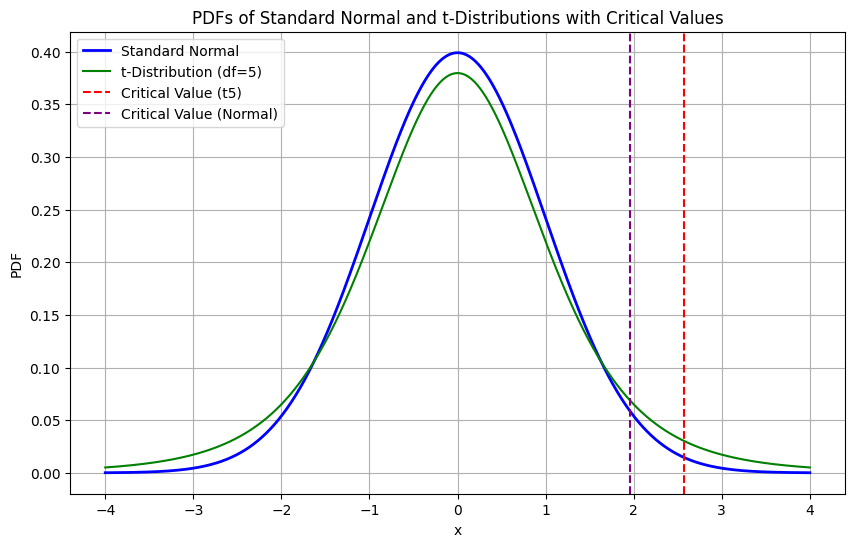

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t

# Define the range of x values
x = np.linspace(-4, 4, 1000)

# Calculate the PDFs for different distributions
pdf_standard_normal = norm.pdf(x)
pdf_t5 = t.pdf(x, df=5)

# Define the desired confidence level (e.g., 95%)
confidence_level = 0.95

# Calculate the critical values for t5 and standard normal distributions
critical_value_t5 = t.ppf(1 - (1 - confidence_level) / 2, df=5)
critical_value_normal = norm.ppf(1 - (1 - confidence_level) / 2)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(x, pdf_standard_normal, label='Standard Normal', linewidth=2, color='blue')
plt.plot(x, pdf_t5, label='t-Distribution (df=5)', color='green')

# Add vertical lines for critical values
plt.axvline(x=critical_value_t5, color='red', linestyle='--', label='Critical Value (t5)')
plt.axvline(x=critical_value_normal, color='purple', linestyle='--', label='Critical Value (Normal)')

# Customize the plot
plt.title('PDFs of Standard Normal and t-Distributions with Critical Values')
plt.xlabel('x')
plt.ylabel('PDF')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
